In [7]:
from scipy.optimize import curve_fit
from functools import wraps
import matplotlib.pyplot as plt
import scipy

from coffea.util import load

import json
import numpy as np

class HepDataParser:
    """
    A class to parse HEPData JSON files and extract cross sections, errors, 
    and correlation matrices.
    """
    
    def __init__(self):
        pass
        
    @staticmethod
    def parse_cross_section(json_file_path):
        """
        Parses the main cross section JSON file to extract:
        - Bin edges
        - Central values (observed cross section)
        - Statistical errors
        - Systematic errors
        
        Returns:
            dict: Dictionary with 'bins', 'values', 'stat_errors', 'syst_errors'
        """
        with open(json_file_path, 'r') as f:
            data = json.load(f)
        
        result = {'bins': [], 'values': [], 'stat_errors': [], 'syst_errors': []}
        
        for entry in data['values']:
            # Extract bin edges
            bin_low = entry['x'][0]['low']
            bin_high = entry['x'][0]['high']
            result['bins'].append((float(bin_low), float(bin_high)))
            
            # Extract central value
            result['values'].append(float(entry['y'][0]['value']))
            
            # Extract errors
            for error in entry['y'][0]['errors']:
                if error.get('label') == 'stat':
                    result['stat_errors'].append(float(error['symerror']))
                elif error.get('label') == 'syst':
                    result['syst_errors'].append(float(error['symerror']))
        
        # Convert to numpy arrays
        for key in ['values', 'stat_errors', 'syst_errors']:
            result[key] = np.array(result[key])
            
        return result

    @staticmethod
    def parse_correlation_matrix(json_file_path, bins):
        """
        Parses the correlation matrix JSON file and constructs a proper matrix.
        
        Returns:
            np.ndarray: Correlation matrix of shape (n_bins, n_bins)
        """
        with open(json_file_path, 'r') as f:
            data = json.load(f)
        
        # Initialize correlation matrix
        n_bins = len(bins)
        corr_matrix = np.eye(n_bins)
        
        # Create a mapping from bin ranges to indices
        bin_to_index = {}
        for idx, (low, high) in enumerate(bins):
            bin_to_index[(low, high)] = idx
        
        # Fill the correlation matrix from the JSON data
        for entry in data['values']:
            # Get bin ranges from the x values
            x_bins = entry['x']
            bin1 = (float(x_bins[0]['low']), float(x_bins[0]['high']))
            bin2 = (float(x_bins[1]['low']), float(x_bins[1]['high']))
            
            # Get the correlation value and convert from percentage to fraction
            correlation_value = float(entry['y'][0]['value']) / 100.0
            
            # Find the indices for these bins
            if bin1 in bin_to_index and bin2 in bin_to_index:
                i = bin_to_index[bin1]
                j = bin_to_index[bin2]
                corr_matrix[i, j] = correlation_value
                corr_matrix[j, i] = correlation_value  # Symmetric matrix
        
        return corr_matrix
    
    @staticmethod
    def build_covariance_matrix(errors, correlation_matrix):
        """
        Builds covariance matrix from errors and correlation matrix.
        
        Args:
            errors (np.array): Array of errors (statistical or systematic)
            correlation_matrix (np.ndarray): Correlation matrix
            
        Returns:
            np.ndarray: Covariance matrix
        """
        n_bins = len(errors)
        covariance_matrix = np.zeros((n_bins, n_bins))
        
        for i in range(n_bins):
            for j in range(n_bins):
                covariance_matrix[i, j] = errors[i] * errors[j] * correlation_matrix[i, j]
        
        return covariance_matrix
    
    def get_inverse_covariance_matrix(self):
        pt_data = HepDataParser.parse_cross_section("json_files/diff_xsec_photon_pt.json")
        bins_pt = pt_data['bins']
        corr_stat_pt = HepDataParser.parse_correlation_matrix("json_files/stat_corr_pt.json", bins_pt)
        corr_syst_pt = HepDataParser.parse_correlation_matrix("json_files/syst_corr_pt.json", bins_pt)
        V_stat_pt = HepDataParser.build_covariance_matrix(pt_data['stat_errors'], corr_stat_pt)
        V_syst_pt = HepDataParser.build_covariance_matrix(pt_data['syst_errors'], corr_syst_pt)
        V_pt = V_stat_pt + V_syst_pt
        V_pt
        
        deltaphi_data = HepDataParser.parse_cross_section("json_files/deltaphi_ll.json")
        bins_deltaphi = deltaphi_data['bins']
        corr_stat_deltaphi = HepDataParser.parse_correlation_matrix("json_files/stat_corr_deltaphi.json", bins_deltaphi)
        corr_syst_deltaphi = HepDataParser.parse_correlation_matrix("json_files/syst_corr_deltaphi.json", bins_deltaphi)
        V_stat_deltaphi = HepDataParser.build_covariance_matrix(deltaphi_data['stat_errors'], corr_stat_deltaphi)
        V_syst_deltaphi = HepDataParser.build_covariance_matrix(deltaphi_data['syst_errors'], corr_syst_deltaphi)
        V_deltaphi = V_stat_deltaphi + V_syst_deltaphi
        V_deltaphi
        
        # Construct the full data vector and covariance matrix
        # Since cross-observable correlations are not published, we assume block diagonal
        self.y_data = np.concatenate([pt_data['values'], deltaphi_data['values']])
        self.V = scipy.linalg.block_diag(V_pt, V_deltaphi)
        
        # Precompute the inverse covariance matrix for chi2 calculation
        self.V_inv = np.linalg.inv(self.V)
        
        return self.V_inv

class ComputeLimit:
    xsec_TT = 1
    def __init__(self, mass):
        self.output = load("output/output.coffea")
        self.mass = mass

    def compute_prefactor(self, width, coupling):
        return width/(coupling**2)

    def fit_decorator(func):
        @wraps(func)
        def wrapper(self, x, y, **kwarg):
            def fitting_function(x_data, a):
                return func(self, x_data, a)
            return curve_fit(fitting_function, x, y, **kwarg)
        return wrapper

    @fit_decorator
    def fit_prefactor(self, x, a):
        return a * x

    def compute_fiducial_acceptance(self, hist_name, mass):
        dataset = list(self.output["hists"]["total"][hist_name][mass].keys())[0]
        hist = list(self.output["hists"]["total"][hist_name][mass].values())[0]
        values = hist.values()
        xsec = self.output["metadata"][mass][dataset]["xsec"]
        lumi = 138
        
        return values/(xsec * lumi)
    
    def compute_branching_ratios(self, g3g, g3gamma):
        """
        Calculates branching ratios B_g and B_gamma for given couplings.
        This uses the formulas from the paper and the prefactors you calculated.

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            tuple: (B_g, B_gamma) branching ratios.
        """
        
        ggluon2 = []
        ggamma2 = []
        width_gamma = []
        width_gluon = []
        width_wb = []
        for dataset, metadata in self.output["metadata"][self.mass].items():
            ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
            ggamma2.append((metadata["gammaFlag"] * metadata["fvec3"])**2)
            width_gamma.append(metadata["width_T_ta"])
            width_gluon.append(metadata["width_T_tg"])
            width_wb.append(metadata["width_T_wb"])
        
        # Calculate prefactor
        xt = (173.0 / self.mass) ** 2  # xt = (mt / mT)^2
        width_factor = ((self.mass ** 3) / (3000 ** 2)) * (1 - xt) ** 3  # Lambda = 3000 GeV (3 TeV)
        gamma_width_factor = width_factor * np.array(ggamma2)
        gluon_width_factor = width_factor * np.array(ggluon2)
        
        gluon_prefactor = self.fit_prefactor(gluon_width_factor, width_gluon)[0][0]
        gamma_prefactor = self.fit_prefactor(gamma_width_factor, width_gamma)[0][0]
        wb_prefactor = curve_fit(lambda a, x: a * x, ggamma2, width_wb)[0][0]  # width_T_wb = prefactor * fvec3**2 and fvec3 = ggamma/gluonFlag

        Gamma_tg = gluon_prefactor * width_factor * (g3g ** 2)
        Gamma_tgamma = gamma_prefactor * width_factor * (g3gamma ** 2)
        Gamma_wb = wb_prefactor * (g3gamma ** 2)

        # Assuming these are the only decay channels
        Gamma_total = Gamma_tg + Gamma_tgamma + Gamma_wb

        # Calculate Branching Ratios
        B_g = Gamma_tg / Gamma_total
        B_gamma = Gamma_tgamma / Gamma_total

        return B_g, B_gamma
        
    def get_signal_vector(self, g3g, g3gamma):
        """
        Constructs the signal prediction vector s for given couplings.
        (Eq. 7 in the paper)

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            np.array: Signal vector s (concatenated pT_gamma and DeltaPhi_ll bins)
        """
        # 1. Get the branching ratios
        B_g, B_gamma = self.compute_branching_ratios(g3g, g3gamma)
        f1gamma = 2 * B_gamma * B_g  # Probability for 1 gamma in TTbar event

        # 2. Get the normalized template shapes for a reference coupling (1, 1)
        # The shape is assumed to be independent of the coupling strength, only the normalisation changes.
        # This is a key assumption from the paper (afid is precomputed from MC).
        fiducial_acceptance_pt = self.compute_fiducial_acceptance("diff_xsec_photon_pt", self.mass)
        fiducial_acceptance_deltaphi = self.compute_fiducial_acceptance("deltaphi_ll", self.mass)

        # 3. Calculate the predicted fiducial cross section in each bin
        # sigma_X,i_fid = sigma_pair * f1gamma * a_X,i_fid
        ggluon2 = []
        xsec_TT = []
        for dataset, metadata in self.output["metadata"][self.mass].items():
            ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
            xsec_TT.append(metadata["xsec_TT"])
        # sigma_TT = a + b * g3g ** 2 + c * g3g ** 4
        xsec_TT_prefactors = curve_fit(lambda a, b, c, x: a + b * x + c * x **2, ggluon2, xsec_TT)
        sigma_TT = xsec_TT_prefactors[0][0] + xsec_TT_prefactors[0][1] * g3g ** 2 + xsec_TT_prefactors[0][2] * g3g **4
        
        
        s_pT = sigma_TT * f1gamma * fiducial_acceptance_pt
        s_dphi = sigma_TT * f1gamma * fiducial_acceptance_deltaphi

        # 4. Concatenate the vectors to form the full signal prediction
        s_total = np.concatenate([s_pT, s_dphi])
        return s_total
        
    def chi2(self, g3g, g3gamma):
        """
        Calculates the chi2 test statistic for given couplings.
        (Eq. 8 in the paper: s^T V^{-1} s)

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            float: The chi2 value.
        """
        s_vec = self.get_signal_vector(g3g, g3gamma)
        # The paper assumes the SM is the null hypothesis (data = 0),
        # and s is the NP signal prediction.
        V_inv = HepDataParser().get_inverse_covariance_matrix()
        chi2_val = s_vec @ V_inv @ s_vec
        return chi2_val
    
    def plot(func):
        @wraps(func)
        def wrapper(self, **kwargs):
            X, Y, Z = func(self, **kwargs)
            plt.contour(X, Y, Z, levels=[5.99])
            plt.xlabel('$g_{3g}$')
            plt.ylabel('$g_{3\\gamma}$')
            plt.title(f'95% CL Exclusion Contour for mT = {self.mass} GeV')
            plt.show()
        return wrapper
            
    
    @plot
    def find_contour(self, g3g_range=(0.5, 1.5), g3gamma_range=(0.5, 1.5), n_points=20):
        """
        Scans the (g3g, g3gamma) parameter space and finds the 95% CL contour.

        Args:
            g3g_range (tuple): (min, max) range for g3g scan.
            g3gamma_range (tuple): (min, max) range for g3gamma scan.
            n_points (int): Number of points along each axis.

        Returns:
            tuple: (X, Y, Z) meshgrid arrays and the chi2 values on the grid.
        """
        g3g_vals = np.linspace(g3g_range[0], g3g_range[1], n_points)
        g3gamma_vals = np.linspace(g3gamma_range[0], g3gamma_range[1], n_points)
        G3g, G3gamma = np.meshgrid(g3g_vals, g3gamma_vals)
        Chi2Grid = np.zeros_like(G3g)

        # Calculate chi2 for each point in the grid
        for i, g3g_val in enumerate(g3g_vals):
            for j, g3gamma_val in enumerate(g3gamma_vals):
                # Avoid (0, 0) to prevent division by zero in BR calculation
                if g3g_val == 0 and g3gamma_val == 0:
                    Chi2Grid[j, i] = 0
                else:
                    Chi2Grid[j, i] = self.chi2(g3g_val, g3gamma_val)

        return G3g, G3gamma, Chi2Grid
        

/home/mohammad/My_Data/top/Dr_Mohammadi_project/codes/env/lib/python3.7/site-packages/ipykernel_launcher.py:290: UserWarning: No contour levels were found within the data range.


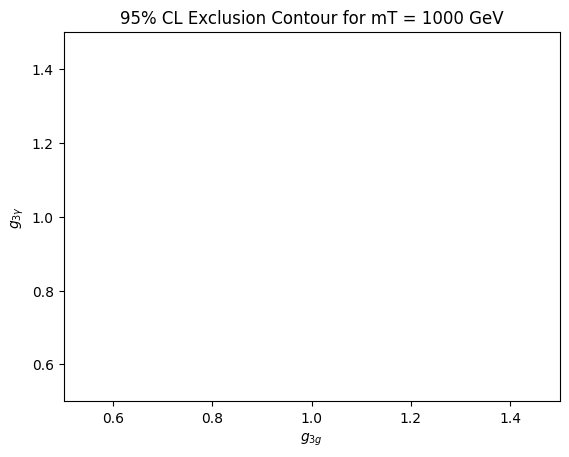

In [8]:
compute_limit = ComputeLimit(1000)
# output = load("output/output.coffea")
# ggluon2 = []
# ggamma2 = []
# width_gamma = []
# width_gluon = []
# for dataset, metadata in output["metadata"][1000].items():
#     ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
#     ggamma2.append((metadata["gammaFlag"] * metadata["fvec3"])**2)
#     width_gamma.append(metadata["width_T_ta"])
#     width_gluon.append(metadata["width_T_tg"])

# # Calculate prefactor
# xt = (173.0 / 1000) ** 2  # xt = (mt / mT)^2
# width_factor = ((1000 ** 3) / (3000 ** 2)) * (1 - xt) ** 3  # Lambda = 3000 GeV (3 TeV)
# gamma_width_factor = width_factor * np.array(ggamma2)
# gluon_width_factor = width_factor * np.array(ggluon2)

# gluon_prefactor = compute_limit.fit_prefactor(gluon_width_factor, width_gluon)
# gamma_prefactor = compute_limit.fit_prefactor(gamma_width_factor, width_gamma)
# print(gluon_prefactor[0][0])
# print(gamma_prefactor)

compute_limit.find_contour()

In [40]:
a = {2: [2,4]}
a.keys()

dict_keys([2])

In [19]:
# metadata: massT, xsec_process, width of all branches of T decay 

In [ ]:
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit, minimize
from functools import wraps
from coffea.util import load
import hepdata_lib  # You might need this or a custom function to read HEPData
# If not using hepdata_lib, you can load the data manually, e.g., from a JSON file.

# Assume you have a function or a table to get the QCD pair production cross section.
# This is often obtained from a theoretical calculator like Top++ or NNLO.
def get_sigma_pair(mT):
    """
    Returns the NNLO cross section (in pb) for pp->TTbar at sqrt(s)=13.6 TeV for a given mT.
    You need to implement this function, e.g., from a pre-calculated list or a fit.
    """
    # Example: A placeholder dictionary. You MUST replace this with actual values.
    # mT values should be in GeV.
    xsec_dict = {
        1000: 0.1,   # pb
        1200: 0.05,  # pb
        1500: 0.01   # pb
    }
    # Simple interpolation if mT is between points, or return the closest value.
    masses = np.array(list(xsec_dict.keys()))
    xsecs = np.array(list(xsec_dict.values()))
    return np.interp(mT, masses, xsecs)


class ComputeLimit:
    def __init__(self, mT, hepdata_path):
        """
        Initialize the class for a specific vector-like top mass mT.

        Args:
            mT (float): Mass of the T quark in GeV.
            hepdata_path (str): Path to the HEPData submission for the tt+gamma measurement.
        """
        self.mT = mT
        self.output = load("output.coffea")  # Load your Coffea file with histograms

        # Get the signal templates for this mass point.
        # Assuming your coffea file has a structure like:
        # output['templates'][mT][g3g_key][g3gamma_key][variable_name]
        # You need to know the keys used for your generated samples.
        # Let's assume you have a reference template for a specific coupling point, e.g., (g3g=1.0, g3gamma=1.0)
        self.template_ref = self.output['templates'][mT][1.0][1.0]

        # Get the experimental data and covariance matrix from HEPData
        self.y_data, self.V = self._load_hepdata(hepdata_path)
        # Precompute the inverse covariance matrix for chi2 calculation
        self.V_inv = np.linalg.inv(self.V)

        # Get the pair production cross section for this mass
        self.sigma_pair = get_sigma_pair(self.mT) * 1000  # Convert pb -> fb to match HEPData

    def _load_hepdata(self, path):
        """
        Loads the unfolded data and covariance matrix from a HEPData submission.

        Args:
            path (str): Path to the HEPData directory or file.

        Returns:
            y_data (np.array): Concatenated data vector for pT_gamma and DeltaPhi_ll.
            V_total (np.ndarray): Combined covariance matrix.
        """
        # This is a complex step. You need to parse the specific HEPData submission.
        # The following is a PLACEHOLDER structure.

        # Option 1: Using the hepdata_lib library
        # submission = hepdata_lib.Submission(path)
        # table = submission.tables[0] # You need to know the correct table index
        # y_pT = np.array(table.variables[0].values) # pT_gamma data
        # y_dphi = np.array(table.variables[1].values) # DeltaPhi_ll data
        # V_pT = ... # Build from table.uncertainties
        # V_dphi = ... # Build from table.uncertainties

        # Option 2: Manual import (e.g., if you saved the data as numpy files)
        # y_pT = np.load('hepdata_y_pT.npy')
        # y_dphi = np.load('hepdata_y_dphi.npy')
        # V_pT = np.load('hepdata_V_pT.npy')
        # V_dphi = np.load('hepdata_V_dphi.npy')

        # Since cross-observable correlations are unknown, we assume block diagonal.
        # y_data = np.concatenate([y_pT, y_dphi])
        # V_total = scipy.linalg.block_diag(V_pT, V_dphi)

        # PLACEHOLDER: Creating dummy data for the example to run.
        # !!! YOU MUST REPLACE THIS WITH REAL DATA FROM HEPDATA !!!
        print("WARNING: Using dummy experimental data. Replace _load_hepdata method.")
        n_bins_pT = 5  # Example number of bins for pT
        n_bins_dphi = 4  # Example number of bins for DeltaPhi
        n_bins_total = n_bins_pT + n_bins_dphi

        y_data = np.ones(n_bins_total)  # Dummy data vector
        V_total = np.eye(n_bins_total)  # Dummy identity covariance matrix

        return y_data, V_total

    def compute_branching_ratios(self, g3g, g3gamma):
        """
        Calculates branching ratios B_g and B_gamma for given couplings.
        This uses the formulas from the paper and the prefactors you calculated.

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            tuple: (B_g, B_gamma) branching ratios.
        """
        # These prefactors k_g and k_gamma MUST be calculated from MadWidth first.
        # You calculated them using compute_prefactor and fit_prefactor.
        # Let's assume you have obtained them for this mass point and stored them.
        k_g = 0.1  # !!! REPLACE WITH YOUR VALUE !!!
        k_gamma = 0.01  # !!! REPLACE WITH YOUR VALUE !!!

        # Calculate partial widths
        xt = (173.0 / self.mT) ** 2  # xt = (mt / mT)^2
        width_factor = (self.mT ** 3) / (1000 ** 2) * (1 - xt) ** 3  # Lambda = 1000 GeV (1 TeV)

        Gamma_tg = k_g * width_factor * (g3g ** 2)
        Gamma_tgamma = k_gamma * width_factor * (g3gamma ** 2)

        # Assuming these are the only decay channels
        Gamma_total = Gamma_tg + Gamma_tgamma

        # Calculate Branching Ratios
        B_g = Gamma_tg / Gamma_total
        B_gamma = Gamma_tgamma / Gamma_total

        return B_g, B_gamma

    def get_signal_vector(self, g3g, g3gamma):
        """
        Constructs the signal prediction vector s for given couplings.
        (Eq. 7 in the paper)

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            np.array: Signal vector s (concatenated pT_gamma and DeltaPhi_ll bins)
        """
        # 1. Get the branching ratios
        B_g, B_gamma = self.compute_branching_ratios(g3g, g3gamma)
        f1gamma = 2 * B_gamma * B_g  # Probability for 1 gamma in TTbar event

        # 2. Get the normalized template shapes for a reference coupling (1, 1)
        # The shape is assumed to be independent of the coupling strength, only the normalisation changes.
        # This is a key assumption from the paper (afid is precomputed from MC).
        template_pT = self.template_ref['photon_pt'].values()
        template_dphi = self.template_ref['lepton_dphi'].values()

        # Normalize the templates to get the fractional contribution per bin (afid)
        # The integral of the template should be 1 before scaling by sigma_pair * f1gamma.
        template_pT_norm = template_pT / np.sum(template_pT)
        template_dphi_norm = template_dphi / np.sum(template_dphi)

        # 3. Calculate the predicted fiducial cross section in each bin
        # sigma_X,i_fid = sigma_pair * f1gamma * a_X,i_fid
        s_pT = self.sigma_pair * f1gamma * template_pT_norm
        s_dphi = self.sigma_pair * f1gamma * template_dphi_norm

        # 4. Concatenate the vectors to form the full signal prediction
        s_total = np.concatenate([s_pT, s_dphi])
        return s_total

    def chi2(self, g3g, g3gamma):
        """
        Calculates the chi2 test statistic for given couplings.
        (Eq. 8 in the paper: s^T V^{-1} s)

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            float: The chi2 value.
        """
        s_vec = self.get_signal_vector(g3g, g3gamma)
        # The paper assumes the SM is the null hypothesis (data = 0),
        # and s is the NP signal prediction.
        chi2_val = s_vec @ self.V_inv @ s_vec
        return chi2_val

    def find_contour(self, g3g_range=(0, 3), g3gamma_range=(0, 3), n_points=20):
        """
        Scans the (g3g, g3gamma) parameter space and finds the 95% CL contour.

        Args:
            g3g_range (tuple): (min, max) range for g3g scan.
            g3gamma_range (tuple): (min, max) range for g3gamma scan.
            n_points (int): Number of points along each axis.

        Returns:
            tuple: (X, Y, Z) meshgrid arrays and the chi2 values on the grid.
        """
        g3g_vals = np.linspace(g3g_range[0], g3g_range[1], n_points)
        g3gamma_vals = np.linspace(g3gamma_range[0], g3gamma_range[1], n_points)
        G3g, G3gamma = np.meshgrid(g3g_vals, g3gamma_vals)
        Chi2Grid = np.zeros_like(G3g)

        # Calculate chi2 for each point in the grid
        for i, g3g_val in enumerate(g3g_vals):
            for j, g3gamma_val in enumerate(g3gamma_vals):
                # Avoid (0, 0) to prevent division by zero in BR calculation
                if g3g_val == 0 and g3gamma_val == 0:
                    Chi2Grid[j, i] = 0
                else:
                    Chi2Grid[j, i] = self.chi2(g3g_val, g3gamma_val)

        return G3g, G3gamma, Chi2Grid


# Example of how to use the class
if __name__ == "__main__":
    # Initialize for a mass point of 1200 GeV
    mass_point = 1200
    analyzer = ComputeLimit(mT=mass_point, hepdata_path="./hepdata_ttgamma_submission")

    # Calculate chi2 for a specific coupling point
    test_chi2 = analyzer.chi2(g3g=1.5, g3gamma=0.5)
    print(f"χ² for (g3g=1.5, g3gamma=0.5) at mT={mass_point} GeV: {test_chi2:.2f}")

    # Find the contour
    G3g_grid, G3gamma_grid, Chi2_grid = analyzer.find_contour(n_points=15)

    # The 95% CL contour for 2 parameters is at χ² = 5.99
    # You can use matplotlib to plot the contour:
    # import matplotlib.pyplot as plt
    # plt.contour(G3g_grid, G3gamma_grid, Chi2_grid, levels=[5.99])
    # plt.xlabel('$g_{3g}$')
    # plt.ylabel('$g_{3\\gamma}$')
    # plt.title(f'95% CL Exclusion Contour for mT = {mass_point} GeV')
    # plt.show()

In [ ]:
g3g_vals = np.linspace(0, 3, 30)
g3gamma_vals = np.linspace(0, 3, 15)
G3g, G3gamma = np.meshgrid(g3g_vals, g3gamma_vals)
Chi2Grid = np.zeros_like(G3g)
G3g

array([[0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
        0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
        1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
        1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
        2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
        2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ],
       [0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
        0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
        1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
        1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
        2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
        2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ],
       [0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
        0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
        1.03448276, 1.13793103, 1.24137931, 1.

In [ ]:
c = ComputeLimit()
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]
c.fit_prefactor(x, y)

(array([1.]), array([[0.]]))

/home/mohammad/My_Data/top/Dr_Mohammadi_project/codes/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


Fitted parameters:
a = 1.161 ± 0.051
b = 265.277 ± nan
c = 1.970 ± 0.122
d = -3.104 ± 0.363
e = -795.720 ± nan
f = 532.458 ± nan


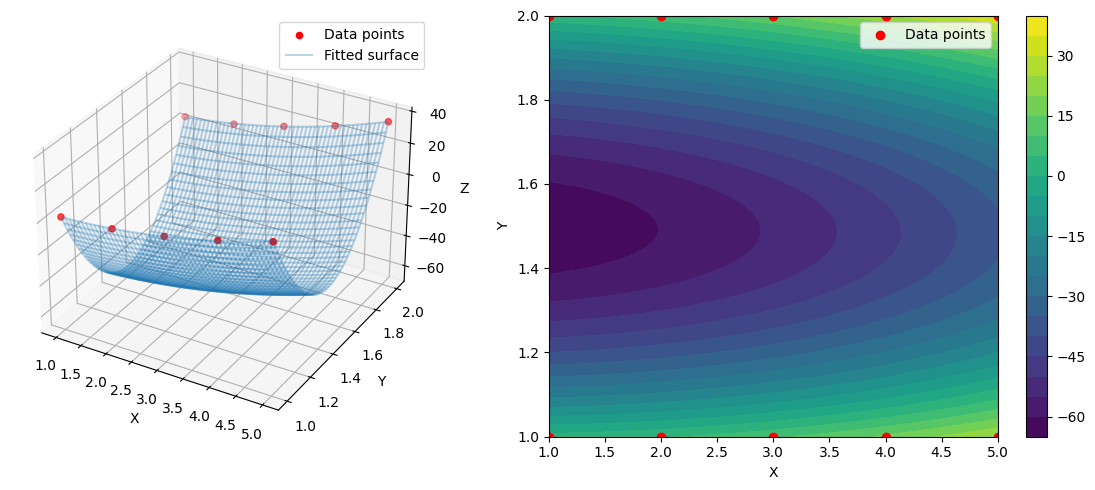

In [19]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample 2D data (replace with your data)
x = np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5])
y = np.array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2])
z = np.array([2.1, 4.2, 9.1, 16.3, 25.2, 4.3, 8.1, 15.2, 24.1, 35.3])

# Define 2D function to fit (example: paraboloid)
def paraboloid(X, a, b, c, d, e, f):
    x, y = X  # Unpack the input
    return a*x**2 + b*y**2 + c*x*y + d*x + e*y + f

# Prepare data for curve_fit
XY = np.vstack((x, y))  # Combine x and y into single array

# Perform the fit
popt, pcov = curve_fit(paraboloid, XY, z)
params = popt
errors = np.sqrt(np.diag(pcov))

print("Fitted parameters:")
param_names = ['a', 'b', 'c', 'd', 'e', 'f']
for name, param, error in zip(param_names, params, errors):
    print(f"{name} = {param:.3f} ± {error:.3f}")

# Generate fitted surface
x_fit = np.linspace(min(x), max(x), 50)
y_fit = np.linspace(min(y), max(y), 50)
X_fit, Y_fit = np.meshgrid(x_fit, y_fit)
Z_fit = paraboloid((X_fit, Y_fit), *params)

# Plot
fig = plt.figure(figsize=(12, 5))

# 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z, color='red', label='Data points')
ax1.plot_wireframe(X_fit, Y_fit, Z_fit, alpha=0.3, label='Fitted surface')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X_fit, Y_fit, Z_fit, 20, cmap='viridis')
ax2.scatter(x, y, color='red', label='Data points')
plt.colorbar(contour, ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()

plt.tight_layout()
plt.show()

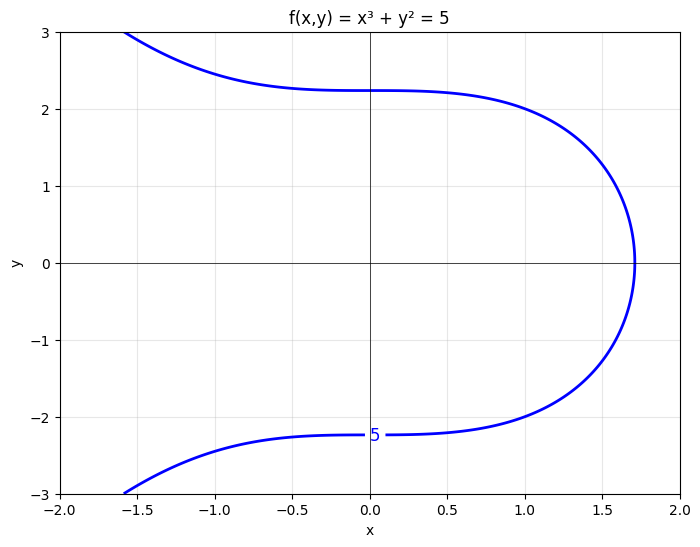

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Create grid of points
x = np.linspace(-2, 2, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)

# Calculate function values
Z = X**3 + Y**2

# Plot the contour where Z = 5
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=[5], colors='blue', linewidths=2)
plt.clabel(contour, inline=True, fontsize=12)

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x,y) = x³ + y² = 5')
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [8]:
dic = {}
for i in s:
    print(i)
    dic.update({i:{}})
dic

a
c
d
b


{'a': {}, 'c': {}, 'd': {}, 'b': {}}

In [5]:
s

{'a', 'b', 'c', 'd'}